# Strategy Backtester for Multiple Stocks
Based on the [strategy_bactester.ipynb](https://github.com/R-Budhidarmo/Technical-Analysis-Backtest/blob/main/strategy_backtester.ipynb) but for analysing multiple stocks in one go.

In [1]:
# import relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import yfinance as yf

from TA_indicators_v2_1 import *
from long_short_screen_v1_3 import *

In [2]:
# define bid/ask spread and the fees
spread = 0.005
fees = 0.05 # per annum

# Load ticker symbols
securities = pd.read_csv('stocks_universe.csv')
tickers = list(securities.iloc[0:50,2]) # The top 50 stocks from S&P500

In [3]:
# Download historical data
df = {} # directory with OHLC value for each stock
period_year = 2
period_days = period_year * 365             
start = dt.datetime.today()-dt.timedelta(period_days)
end = dt.datetime.today()

# iterate over tickers and creating a dataframe with close prices
for ticker in tickers:
    df[ticker] = yf.download(ticker,start,end)#,interval='1mo')
    df[ticker].dropna(inplace=True,how="all")
 
tickers = df.keys() # redefine tickers variable after removing any tickers with corrupted data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
# initiate empty lists for KPIs & dataframe for equity curves
max_DD, max_DD_dur, sharpe, growth_rate,  = [],[],[],[]
equity = pd.DataFrame()

In [5]:
# calculate indicators and strategy KPIs for each ticker

for ticker in tickers:

    # calculate percentage change in the closing price
    df[ticker]['Percent Change'] = df[ticker]['Close'].pct_change()
    
    # calculate technical analysis indicators
    df[ticker][['True Range','ATR']] = ATR(df[ticker])
    df[ticker]['EMA'] = EMA(df[ticker],20)
    df[ticker][['SSL Down','SSL Up']] = SSL(df[ticker],20)
    df[ticker][['VI+','VI-']] = vortex(df[ticker],10)

    # define the entry & exit signals
    long_entry_signal = (df[ticker]['Close'] > df[ticker]['EMA']) & (df[ticker]['VI+'] > df[ticker]['VI-']) & (df[ticker]['SSL Up'] > df[ticker]['SSL Down'])
    long_exit_signal = (df[ticker]['SSL Up'] < df[ticker]['SSL Down'])

    short_entry_signal = (df[ticker]['Close'] < df[ticker]['EMA']) & (df[ticker]['VI-'] > df[ticker]['VI+']) & (df[ticker]['SSL Down'] > df[ticker]['SSL Up'])
    short_exit_signal = (df[ticker]['SSL Down'] < df[ticker]['SSL Up'])

    # call the screener function
    equity[['Equity - Long','Equity - Short','Equity - Long & Short']],maxDD, maxDDDuration, DDDay, sharpeRatio, cagr = long_short_screen(df[ticker], long_entry_signal, long_exit_signal,
                                                        short_entry_signal, short_exit_signal, spread, fees)
    
    # append KPI's to the appropriate list
    max_DD.append(maxDD)
    max_DD_dur.append(maxDDDuration)
    sharpe.append(sharpeRatio)
    growth_rate.append(cagr)

    # generate equity curves & save figures as png
    fig,ax = plt.subplots(figsize=(8,6))
    ax.plot(equity['Equity - Long'],label='Long')
    ax.plot(equity['Equity - Short'],label='Short')
    ax.plot(equity['Equity - Long & Short'],label='Long & Short')
    ax.legend()
    ax.set_ylabel('Equity')
    ax.set_title(f'{ticker}')
    fig.savefig(f'stocks_equity_curve/{ticker}.png')
    plt.close(fig)

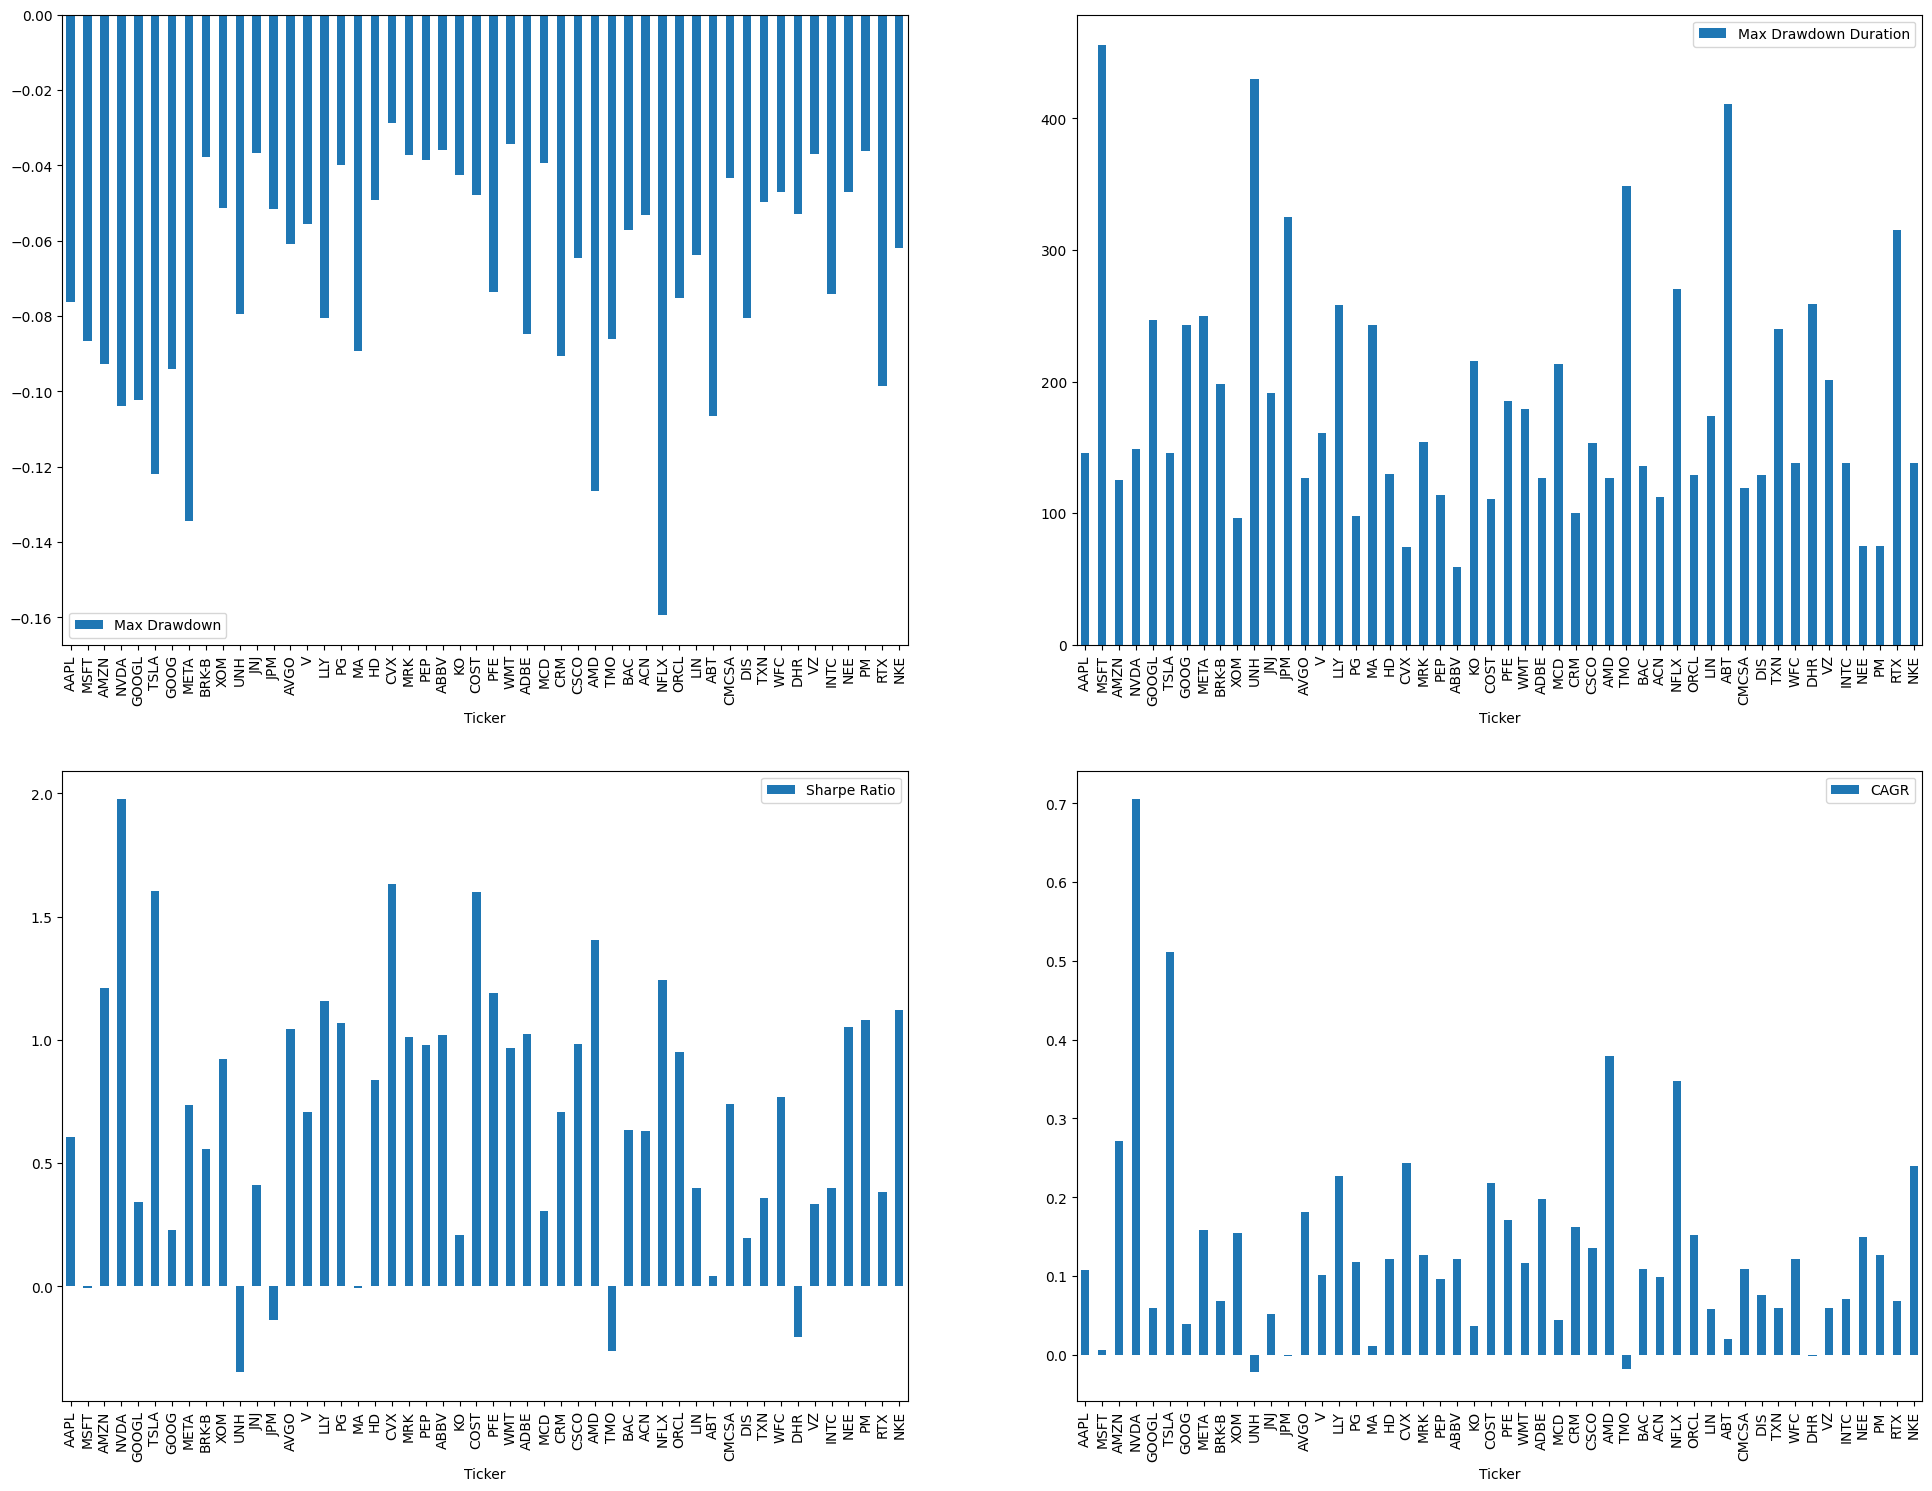

In [6]:
# compile all KPIs in one summary dataframe
summary = pd.DataFrame({'Ticker': tickers, 'Max Drawdown': max_DD, 'Max Drawdown Duration': max_DD_dur,
                        'Sharpe Ratio': sharpe, 'CAGR': growth_rate})
summary.set_index('Ticker', inplace=True)

# visualise the KPIs
nrow = 2
ncol = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(24,18))
count=1
for r in range(nrow):
    for c in range(ncol):
        summary.iloc[:,count-1].plot(kind='bar', ax=axes[r,c])
        axes[r][c].legend()
        count+=1
plt.tight_layout
plt.show()

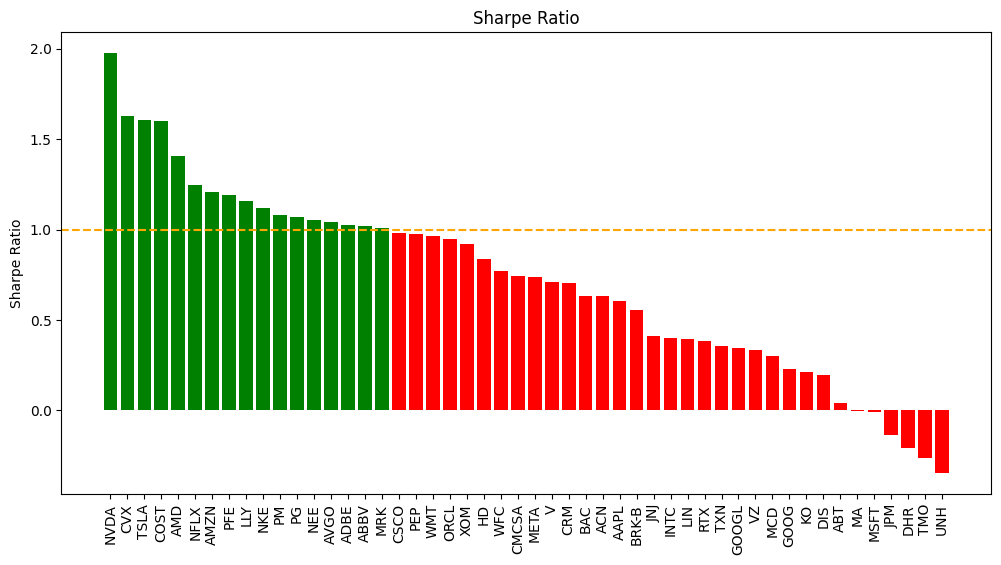

In [7]:
# order stocks based on Sharpe ratios & visualise

sharpe_df = summary['Sharpe Ratio'].copy()
sharpe_df = sharpe_df.sort_values(ascending=False)

sharpe_threshold = 1 # set Sharpe ratio threshold
colors = ['green' if i > sharpe_threshold else 'red' for i in sharpe_df]

fig,ax = plt.subplots(figsize=(12,6))
ax.bar(x=sharpe_df.index, height=sharpe_df, color = colors, label='Sharpe Ratio')
ax.axhline(sharpe_threshold, linestyle='--', color='orange')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio')
plt.xticks(rotation=90)
plt.show()

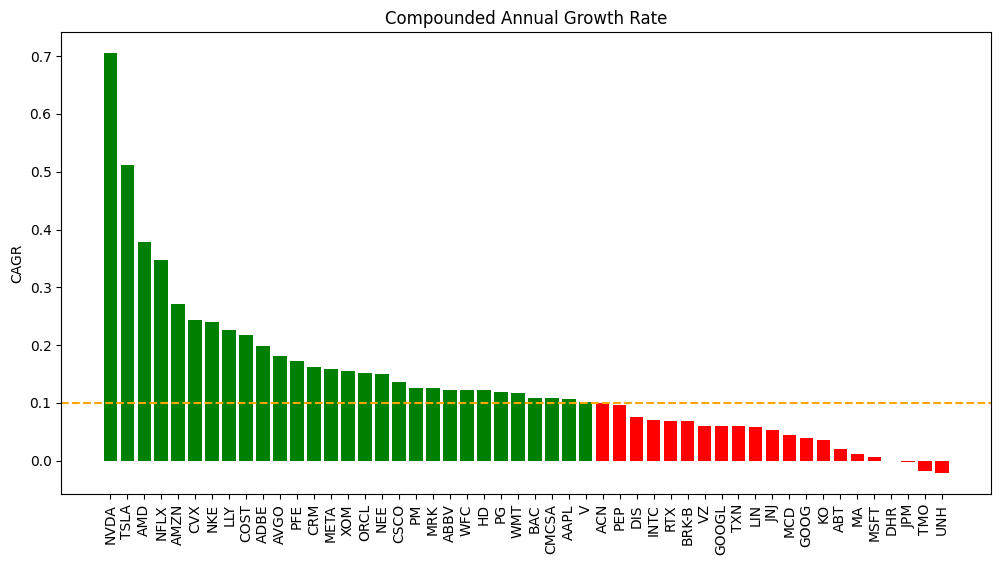

In [8]:
# order stocks based on CAGR & visualise

cagr_df = summary['CAGR'].copy()
cagr_df = cagr_df.sort_values(ascending=False)

cagr_threshold = 0.1 # set CAGR threshold
colors = ['green' if i > cagr_threshold else 'red' for i in cagr_df]

fig,ax = plt.subplots(figsize=(12,6))
ax.bar(x=cagr_df.index, height=cagr_df, color = colors, label='CAGR')
ax.axhline(cagr_threshold, linestyle='--', color='orange')
plt.ylabel('CAGR')
plt.title('Compounded Annual Growth Rate')
plt.xticks(rotation=90)
plt.show()

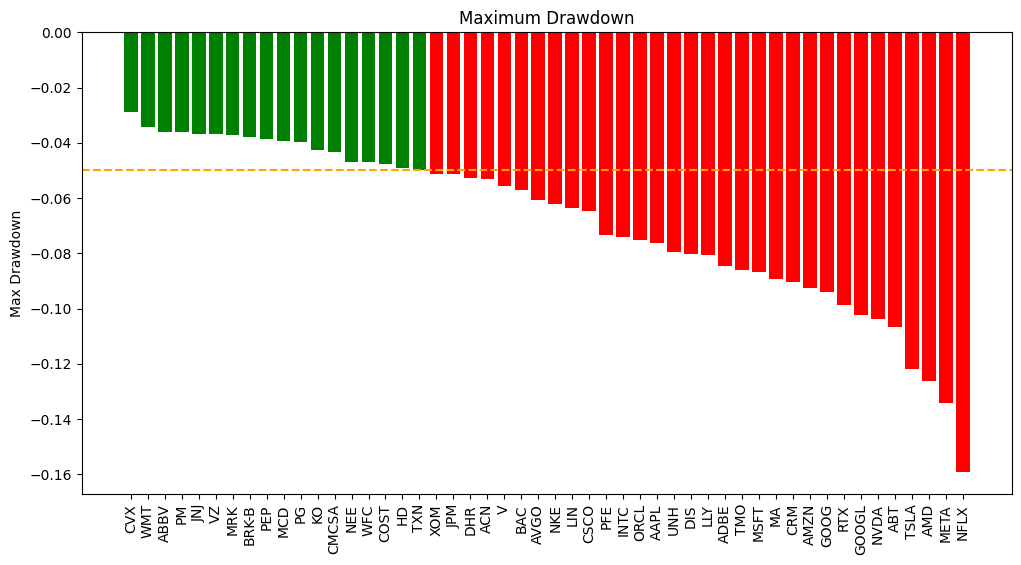

In [9]:
# order stocks based on maximum drawdown & visualise

maxdd_df = summary['Max Drawdown'].copy()
maxdd_df = maxdd_df.sort_values(ascending=False)

maxdd_threshold = -0.05 # set maximum drawdown threshold
colors = ['green' if i > maxdd_threshold else 'red' for i in maxdd_df]

fig,ax = plt.subplots(figsize=(12,6))
ax.bar(x=maxdd_df.index, height=maxdd_df, color = colors, label='Max Drawdown')
ax.axhline(maxdd_threshold, linestyle='--', color='orange')
plt.ylabel('Max Drawdown')
plt.title('Maximum Drawdown')
plt.xticks(rotation=90)
plt.show()

In [10]:
#summary.to_csv('stocks_backtest_7Sep23.csv')